In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
import dicom
import ghalton
from scipy.interpolate import interp1d
from skimage.measure import block_reduce

In [5]:
import sys
sys.path.insert(1,'./code')
from utils import clean
from get_data_res import get_data
from visualize import plot_volumes

In [6]:
list_6_4mm, list_8mm, list_10mm = get_data()

In [7]:
PathDicom = '/Users/zyzdiana/Dropbox/vNav_Test_Data/Mar_18_Test_Data/high_res/'
filenames = clean(os.listdir(PathDicom))
lstFilesDCM = []

for f in filenames:
    lstFilesDCM.append(os.path.join(PathDicom,f))
print len(lstFilesDCM)

352


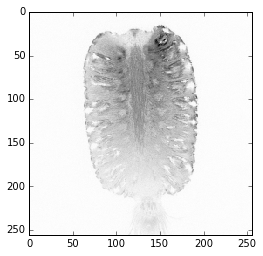

In [8]:
# Show Sample High Resolution Image
ds = dicom.read_file(lstFilesDCM[100])
pic = ds.pixel_array
plt.imshow(pic, interpolation='None', cmap='Greys')
plt.show()

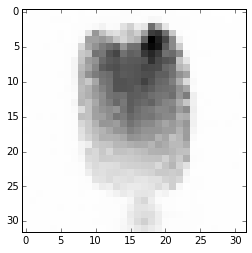

In [9]:
# Example Downsample
pic_red = block_reduce(pic, block_size=(8, 8), func=np.mean)
plt.imshow(pic_red, interpolation='None', cmap='Greys')
plt.show()

In [10]:
def bilinear_interp(image, x, y):
    
    x = np.asarray(x)
    y = np.asarray(y)

    # find the closes grid of the target points
    x1 = np.floor(x).astype(int)
    
    # Take care of boundary conditions
    # check if the input grid x, y is already on the original grid (i.e. special rotations)
    if (np.allclose(x.astype(int),x1)):
        return image[y.astype(int),x.astype(int)]
    
    x2 = x1 + 1
    y1 = np.floor(y).astype(int)
    y2 = y1 + 1
    
    
    # we need to clip the range 
    x1 = np.clip(x1, 0, image.shape[1]-1)
    x2 = np.clip(x2, 0, image.shape[1]-1)
    y1 = np.clip(y1, 0, image.shape[0]-1)
    y2 = np.clip(y2, 0, image.shape[0]-1)

    # get the four know points
    Q11 = image[y1, x1]
    Q21 = image[y1, x2]
    Q12 = image[y2, x1]
    Q22 = image[y2, x2]

    # get weights, note that here we are dealing with 1 grid, so c+d = a+b = 1
    a = x2 - x
    b = x - x1
    c = y - y1
    d = y2 - y

    return a*d*Q11 + b*d*Q21 + a*c*Q12 + b*c*Q22

def to_radian(theta):
    return theta*np.pi/180.

def rotate_coords(x, y, theta, ox, oy):
    """
    Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    # round up the sin and cos to 15 decimals
    s = np.round(s,15)
    c = np.round(c,15)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def imrotate(image, theta, interpolation = 'bilinear', mask=False, x=None, y=None):
    theta = to_radian(theta)
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    if((x == None) and (y == None)): #i.e. x and y not specified
        x = np.linspace(0, image.shape[1]-1, image.shape[1]).astype(int)
        y = np.linspace(0, image.shape[0]-1, image.shape[0]).astype(int)
    
    xx, yy = np.meshgrid(x,y)
    
    dest_x, dest_y = rotate_coords(xx, yy, theta, ox, oy)
    
    if(interpolation == 'bicubic'):
        dest = bicubic_interp(image, dest_x, dest_y)
    if(interpolation == 'bilinear'):
        dest = bilinear_interp(image, dest_x, dest_y)

        
    if(mask):
        dest = circle_mask(dest)
    return dest

In [20]:
def rot_downsample(image, theta, block_size = (8,8)):
    tmp = imrotate(image, theta)
    im_down = block_reduce(image, block_size=block_size, func=np.mean)
    im_rot_down = block_reduce(tmp, block_size=block_size, func=np.mean)
    return im_down, im_rot_down

In [12]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image
def bessel_rotate(image, theta, mask = False):
    t0 = time.time()
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    #image = np.fft.fft2(image)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                #tmp = np.fft.ifft2(scipy.signal.convolve2d(Bess, image, 'valid'))
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return Ib

def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

In [ ]:
min_angles_bess = {}
angles = np.arange(0,180,0.1)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (6,6))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess[ang] = angMin

In [101]:
min_angles_bess_6 = {}
angles = np.arange(0,180,0.1)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (6,6))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess_6[ang] = angMin

0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0 110.0 120.0 130.0 140.0 150.0 160.0 170.0


In [102]:
min_angles_bess_10 = {}
angles = np.arange(0,180,0.1)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (10,10))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess_10[ang] = angMin

0.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0 110.0 120.0 130.0 140.0 150.0 160.0 170.0


In [103]:
import cPickle as pickle
pickle.dump(min_angles_bess, open('blocksize_8_min_angles.p','wb'))
pickle.dump(min_angles_bess_6, open('blocksize_6_min_angles.p','wb'))
pickle.dump(min_angles_bess_10, open('blocksize_10_min_angles.p','wb'))

In [127]:
# Sort the results
y = []
x = sorted(min_angles_bess.keys())
for k in x:
    y.append(min_angles_bess[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

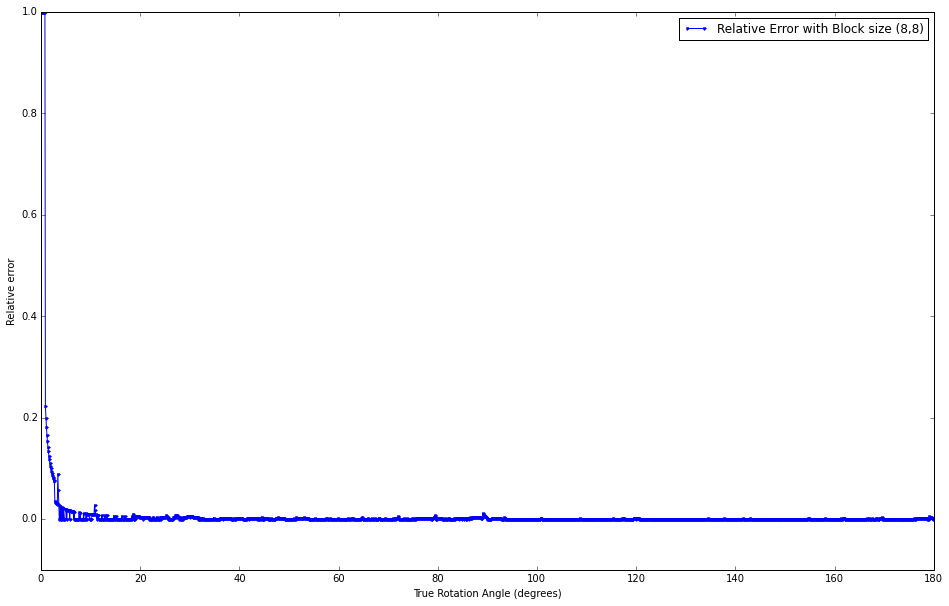

In [128]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (8,8)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

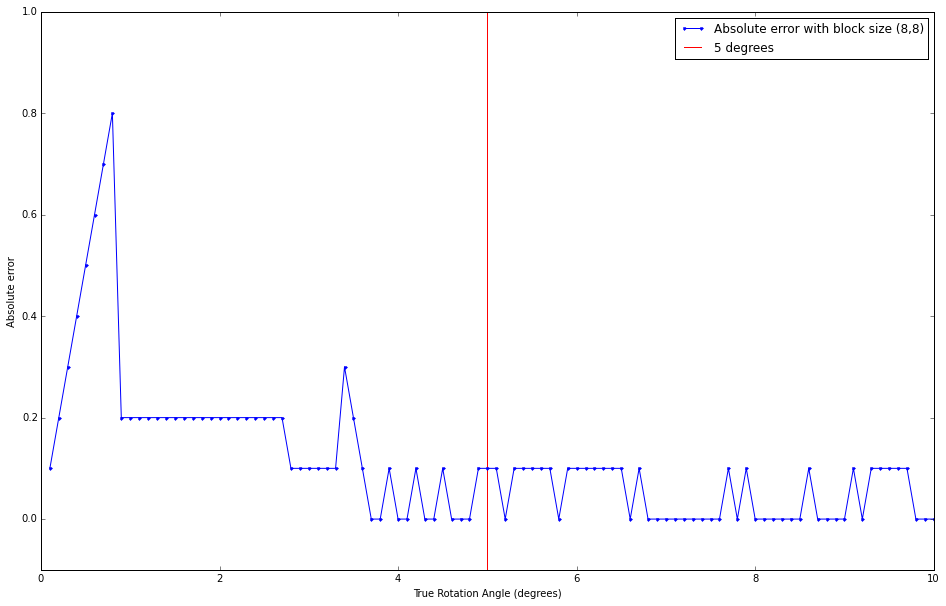

In [129]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:100],abs(y-x)[:100],'.-', label='Absolute error with block size (8,8)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

In [130]:
# Sort the results
y = []
x = sorted(min_angles_bess_6.keys())
for k in x:
    y.append(min_angles_bess_6[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

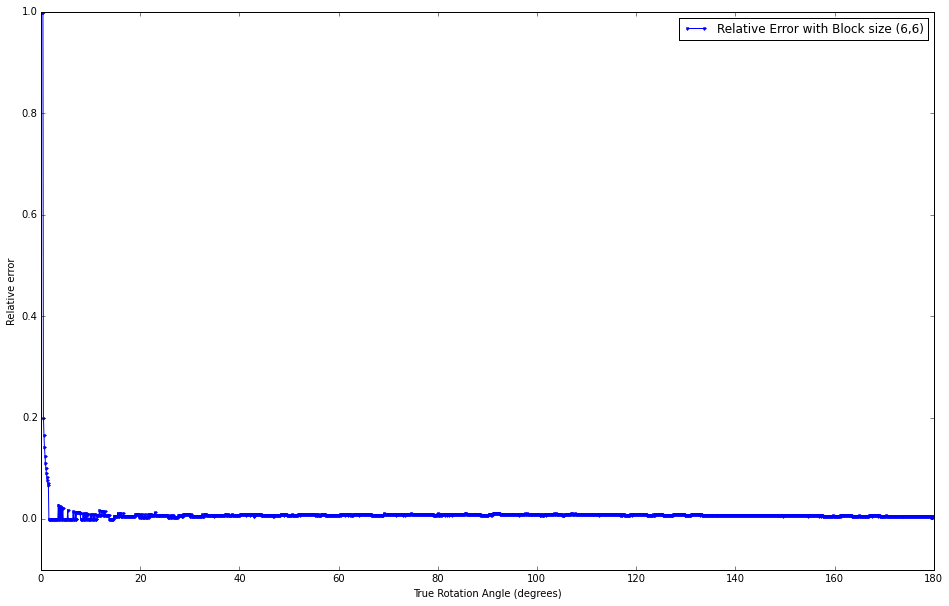

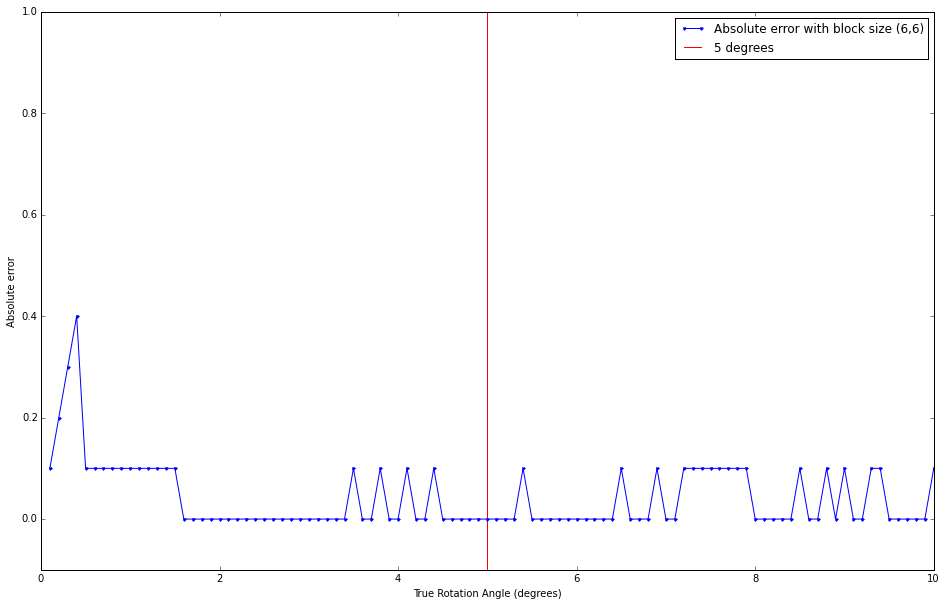

In [131]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (6,6)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:100],abs(y-x)[:100],'.-', label='Absolute error with block size (6,6)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

In [132]:
# Sort the results
y = []
x = sorted(min_angles_bess_10.keys())
for k in x:
    y.append(min_angles_bess_10[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

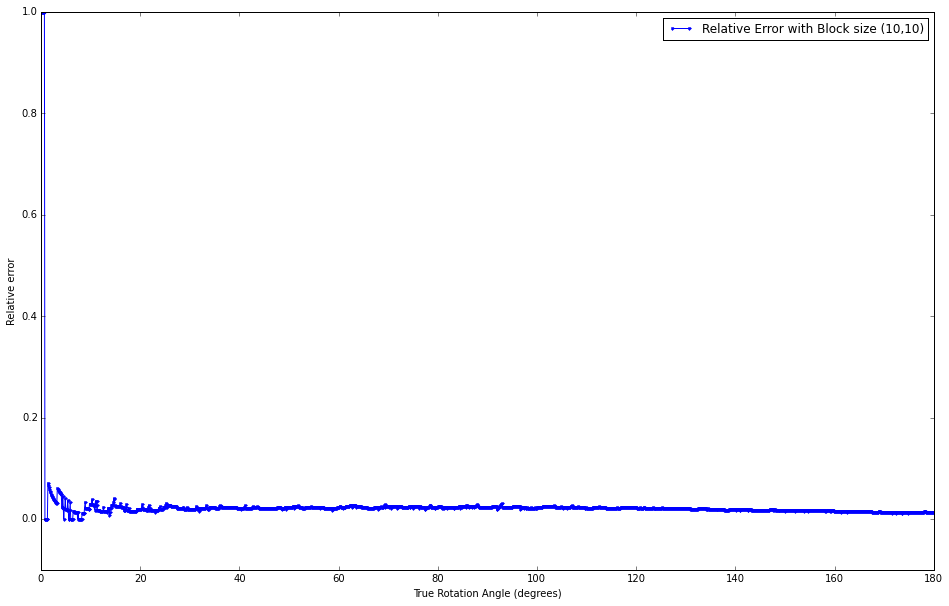

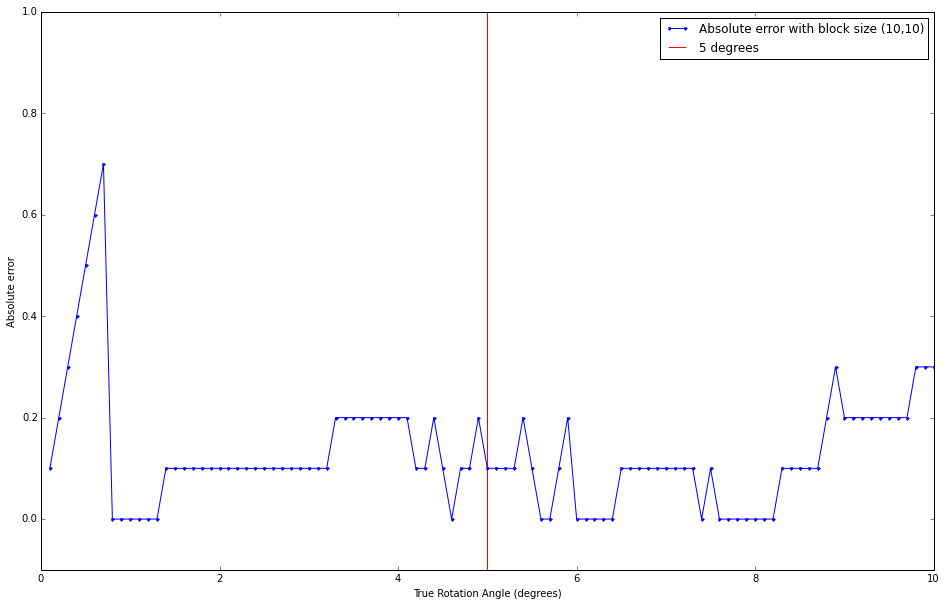

In [133]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (10,10)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:100],abs(y-x)[:100],'.-', label='Absolute error with block size (10,10)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()